# (E18) 프로젝트 : 다양한 OCR모델 비교하기

- Google OCR API, keras-ocr, Tesseract 3가지 OCR모델을 비교하는 프로젝트입니다.
- OCR(Optical Character Recognition, 광학 문자 인식)은 문자를 읽는 기술입니다.

## Step1. 검증용 데이터셋 준비

In [48]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import keras_ocr
import cv2

In [49]:
# 입력 이미지 경로를 지정해 주세요.
path = os.getenv('HOME')+'/aiffel/ocr_python/[E18]OCR'
images = os.listdir(path)
images_path = [path + '/' + i for i in images]
images_path = sorted(images_path)
images_path

['/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/buffet.jpg',
 '/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/map.jpg',
 '/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/poster.jpg',
 '/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/road-sign-1.jpg',
 '/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/road-sign-2.jpg',
 '/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/sign.jpg',
 '/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/sign2.jpg',
 '/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/signboard.jpg']

In [50]:
images = []
image_title = []

for image in images_path:
        img=cv2.imread(image)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)                         
        images.append(img)
        image_title.append(os.path.splitext(os.path.basename(image))[0])
print(image_title)

['buffet', 'map', 'poster', 'road-sign-1', 'road-sign-2', 'sign', 'sign2', 'signboard']


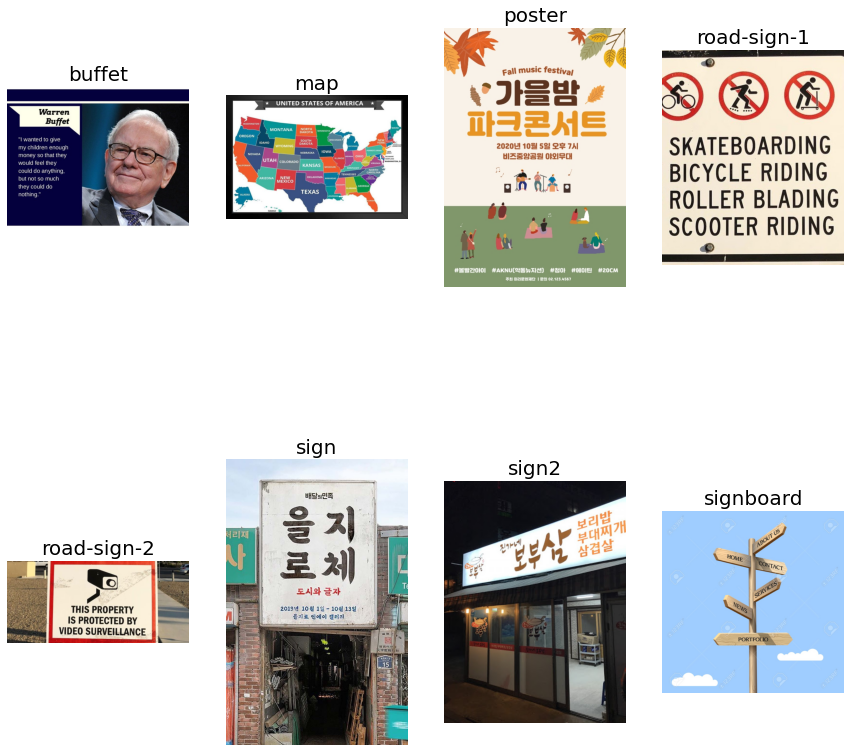

In [51]:
plt.figure(figsize=(15,15))

for i in range(len(images)):
    plt.subplot(2, 4, i+1) 
    plt.imshow(images[i])
    plt.title(image_title[i], fontsize=20)
    plt.axis('off')
    
plt.show()

## Step2. Google OCR API, keras-ocr, Tesseract로 테스트 진행

## 1. Google OCR API


#### 1.1 구글의 파이썬 API 인터페이스 모듈을 아래와 설치합니다.

#### 1.2 Google Cloud Vision API 사용

#### 1.3 인증키 경로 등록 후 커널 재기동

#### 1.4 Google OCR API 사용

In [12]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [13]:
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

for path in images_path:
    detect_text(path)
    print("---------------------------------------------------------------")

-rw-rw-r-- 1 aiffel-dj22 aiffel-dj22 2349  3월 16 10:51 /home/aiffel-dj22/aiffel/ocr_python/my_google_api_key.json
Texts:

"Warren
Buffet
"I wanted to give
my children enough
money so that they
would feel they
could do anything,
but not so much
they could do
nothing."
"

"Warren"

"Buffet"

""I"

"wanted"

"to"

"give"

"my"

"children"

"enough"

"money"

"so"

"that"

"they"

"would"

"feel"

"they"

"could"

"do"

"anything,"

"but"

"not"

"so"

"much"

"they"

"could"

"do"

"nothing.""
bounds: (41,367),(116,367),(116,385),(41,385)
---------------------------------------------------------------
Texts:

"UNITED STATES OF AMERICA
WASHINGTON
MAINE
MONTANA
NORTH
DAKOTA
MINNESOTA
OREGON
NEW
YORK
WISCONSIN
SOUTH
DAKOTA
IDAHO
WYOMING
RHODE ISLA
CONNECTICU
MICHIGAN
PENNSYLVANIA
NEBRASKA
IOWA
NEW
JERSEY
NEVADA
INDIANA OHIO
DELAWARE
ILLINOIS
UTAH
MARYLAND
COLORADO
WEST
VIRGINIA VIRGINIA
WASHINGTON, D.
CALIFORNIA
KANSAS
MISSOURI
KENTUCKY
NORTH
CAROLINA
TENNESSEE
OKLAHOMA
NEW
MEXICO
ARIZONA
SO

## 2. keras-ocr

In [18]:
# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /home/aiffel-dj22/.keras-ocr/craft_mlt_25k.h5
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Looking for /home/aiffel-dj22/.keras-ocr/crnn_kurapan.h5


In [23]:
images = [keras_ocr.tools.read(path) for path in images_path]
prediction_groups = [pipeline.recognize([path]) for path in images_path]

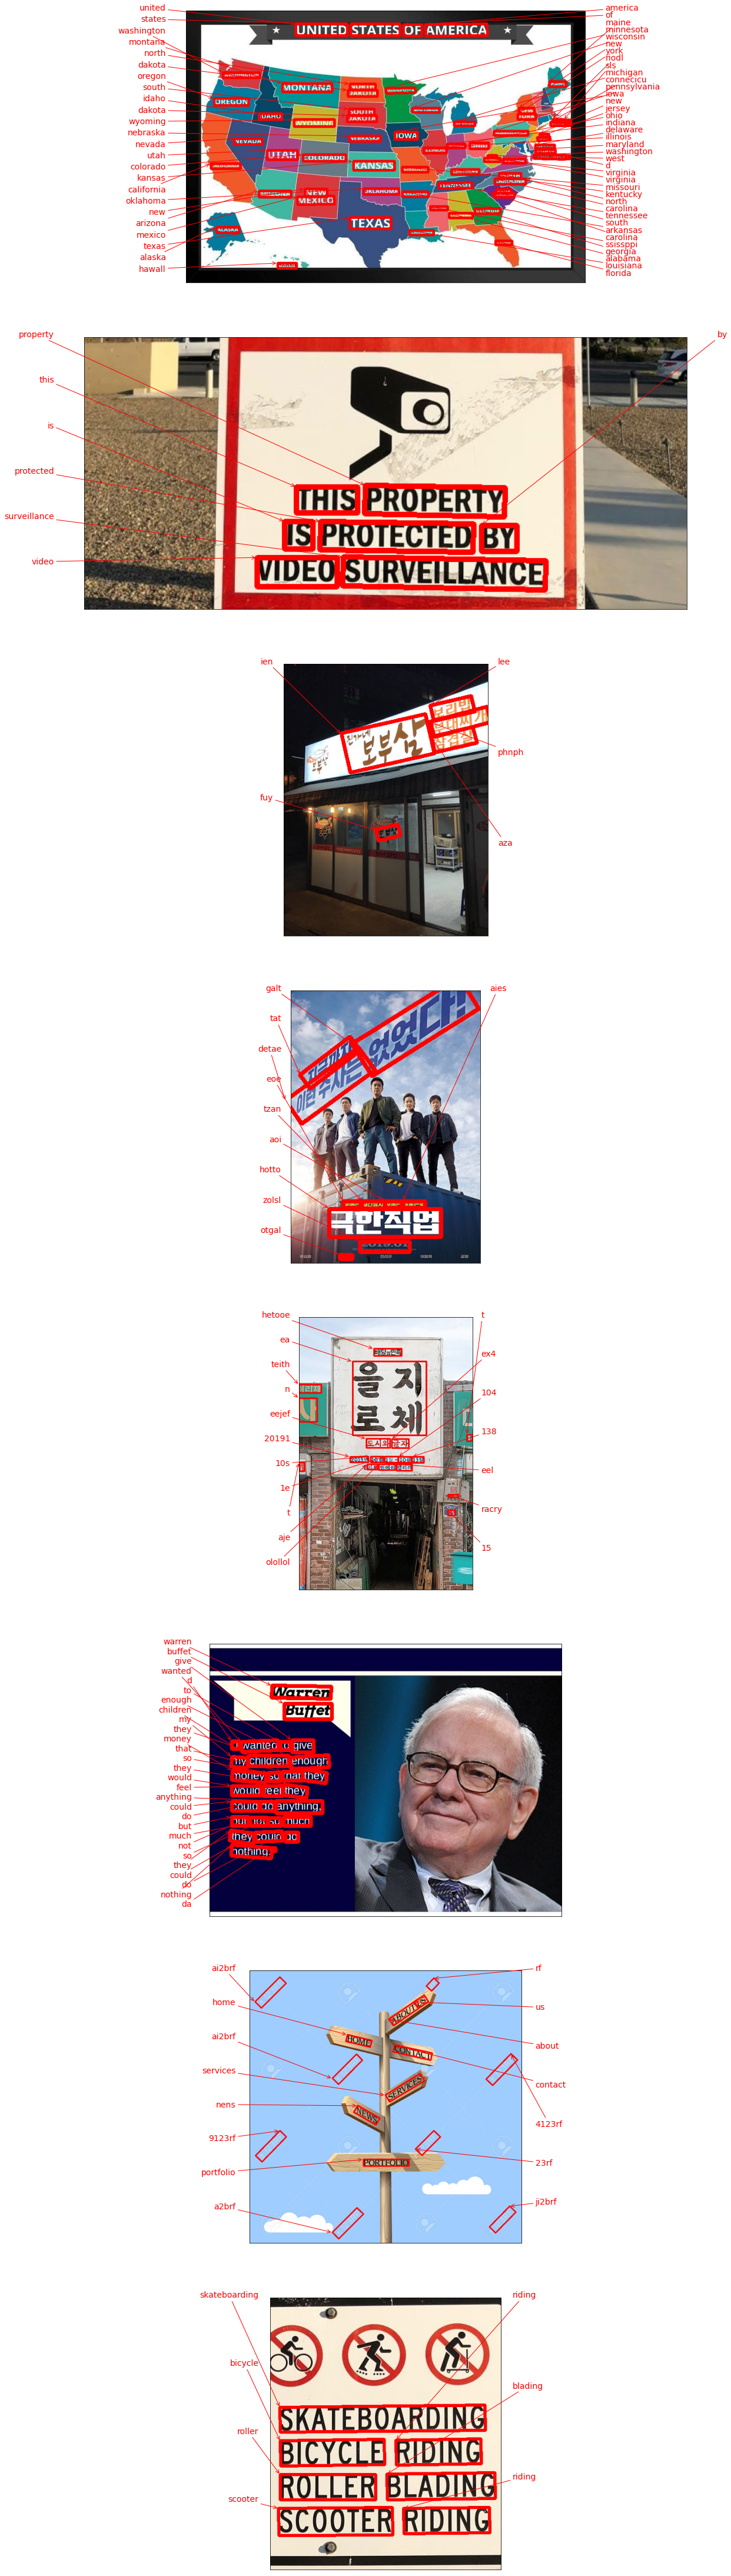

In [25]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(80, 80))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

## 3. Tesseract

#### 1) 테서랙트 설치하기

#### 2) 테서랙트 파이썬 wrapper 설치하기

#### 3.1) 테서랙트로 문자 검출하고 이미지 자르기 (detection)

In [28]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output', lang='lang'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang=lang,    # 영어라면 lang='eng', 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

#### 4) 테서랙트로 잘린 이미지에서 단어 인식하기

In [32]:
def recognize_images(cropped_image_path_list, lang='lang'):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang=lang,    # 영어라면 lang='eng', 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])


#### 5) 영어 단어 인식

In [33]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/[E18]OCR'
img_file_path = work_dir + '/buffet.jpg'
cropped_image_path_list = crop_word_regions(img_file_path, work_dir, lang='eng')

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list, lang='eng')

/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0000.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0001.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0002.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0003.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0004.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0005.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0006.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0007.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0008.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0009.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0010.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0011.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0012.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0013.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0014.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0015.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0016.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0017.png
/home/aiffel-dj22/aiffel/ocr

In [34]:
img_file_path_2 = work_dir + '/road-sign-1.jpg'
cropped_image_path_list_2 = crop_word_regions(img_file_path_2, work_dir, lang='eng')

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list_2, lang='eng')

/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0000.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0001.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0002.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0003.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0004.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0005.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0006.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0007.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0008.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0009.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0010.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0011.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0012.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0013.png

&Q

——

Si)


hr

SKATEBOARDING

BICYCLE

RIDING

ROLLER

BLADING

SCOOTER

RIDING

®



#### 6) 한글 단어 인식

In [38]:
img_file_path_3 = work_dir + '/sign.jpg'
cropped_image_path_list_3 = crop_word_regions(img_file_path_3, work_dir, lang='kor')

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list_3, lang='kor')

/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0000.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0001.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0002.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0003.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0004.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0005.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0006.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0007.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0008.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0009.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0010.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0011.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0012.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0013.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0014.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0015.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0016.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0017.png
201

'겨

1()

커

1

입


In [52]:
img_file_path_4 = work_dir + '/poster.jpg'
cropped_image_path_list_4 = crop_word_regions(img_file_path_4, work_dir, lang='kor')

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list_3, lang='kor')

/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0000.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0001.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0002.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0003.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0004.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0005.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0006.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0007.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0008.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0009.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0010.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0011.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0012.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0013.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0014.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0015.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0016.png
/home/aiffel-dj22/aiffel/ocr_python/[E18]OCR/0017.png
/home/aiffel-dj22/aiffel/ocr

## Step4. 결과 분석과 결론 제시

- Google OCR API와 keras-ocr은 이미지의 영어 글자와 문단을 정확하게 파악한다. Google OCR API의 경우는 한글 글자도 파악하는데 성능이 뛰어나다.
- keras-ocr은 영어 단어로만 학습을 하였기 때문에 한글 단어를 전혀 인식하지 못한다. 
- 마지막 모델인 tesseract는 영어 단어와 한글 단어를 인식하기는 하지만 출력의 결과는 단어 한 글자씩만 나오고 성능이 매우 좋지 못하다. 그러나 글자가 뚜렷한 이미지의 경우, 특히 영어 단어의 경우에 정확한 성능을 나타내는 것을 확인할 수 있었다.
  

- OCR 모델 평가 기준

|평가기준|Google OCR API|Keras-ocr|Tesseract|
|---|---|---|---|
|1. 전체적인 글자 인식|O|O|X|
|2. 한글 인식|O|X|O|
|3. 인식률 순위|1|2|3|
|4. 단어 완성도|O|O|X|


## 루브릭

1. OCR을 활용하여 구현하려는 서비스의 기획이 타당한가?(목표로 하는 서비스가 OCR를 적용 가능하며, OCR을 활용했을 때 더욱 유용해진다.)

- OCR을 활용하여 신용카드의 번호나 우편물의 우편번호를 추출하여 편리함을 줄 수 잇다.

2. 모델 평가기준이 명확하고 체계적으로 세워졌는가?(평가 기준에 부합하는 테스트 데이터의 특징이 무엇인지 명확하게 제시되었다.)

- 모델 평가기준은 위의 결과와 같이 나타내었습니다.

3. 평가기준에 따라 충분한 분량의 테스트가 진행되고 그 결과가 잘 정리되었는가?(최대 20장까지의 테스트 이미지를 사용해 제시된 평가 기준에 따른 테스트 결과가 잘 정리되어 결론이 도출되었다.)

- 총 8장의 영어 단어와 한글 단어로 이루어진 이미지를 사용하여 프로젝트를 진행하였고, 결과를 도출하였습니다.

## 회고

- 구글이 제공하고 있는 어플 구글 렌즈를 사용해본적이 있었는데, Googl OCR API을 이용하여 서비스가 이루어진다는 것을 배울 수 있었다. google ocr api는 상당히 많은 데이터로 학습을 진행하였기 때문에 성능이 높은 것으로 보인다.
- keras에 내장되어 있는 모듈로도 높은 인식률을 낼 수 있었다. 간결한 코드로 이용할 수 있어 굉장히 편리하였다.
- tesseract는 텍스트가 있는 위치를 잘 파악하지만, 성능이 매우 좋지 못하다. 성능을 높이기 위해 학습이 더 필요할 것 같다.